In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/molgen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
model_class = class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.00, count_rollouts: 1, reward: -0.9179237992977742, node: PEPTIDE1{[ac].F.P.S.K.K.N.V.F.V.F.G.Y.F.E.R.[dL].R.A.K.L.[am]}$$$$
1- time: 0.06, count_rollouts: 2, reward: -0.9357094396831224, node: PEPTIDE1{F.F.N.L.K.Y.H.L.D.I.E.F.I.K.E.I.H.E.Q.Q.E.N.M.Q.L.N.L}$$$$
2- time: 0.14, count_rollouts: 3, reward: -0.9264870306979995, node: PEPTIDE1{[ac].F.Q.S.K.G.N.V.F.V.D.G.Y.F.E.R.L.K.A.K.L.[am]}$$$$
3- time: 0.19, count_rollouts: 4, reward: -0.8840130335515616, node: PEPTIDE1{R.[dP].K.[dP].[dQ].[dQ].F.[dF].G.L.M.[am]}$$$$
4- time: 0.23, count_rollouts: 5, reward: -0.8901310935182828, node: PEPTIDE1{Y.V.P.T.N.V.G.S.E.A.F}$$$$
5- time: 0.31, count_rollouts: 7, reward: -0.9127788994067226, node: PEPTIDE1{F.[dF].G.F.T.G.A.R.K.S.A.R.K.[am]}$$$$
6- time: 0.34, count_rollouts: 8, reward: -0.9256728064795466, node: PEPTIDE1{A.L.R.K.Y.K.R.R.R.P.K.R.R}$$$$
7- time: 0.38, count_rollouts: 9, reward: -0.9030788205143876, node: PEPTIDE1{T.P.R.E.R.R.R.K.K.R.G.[am]}$$$$
8- time: 

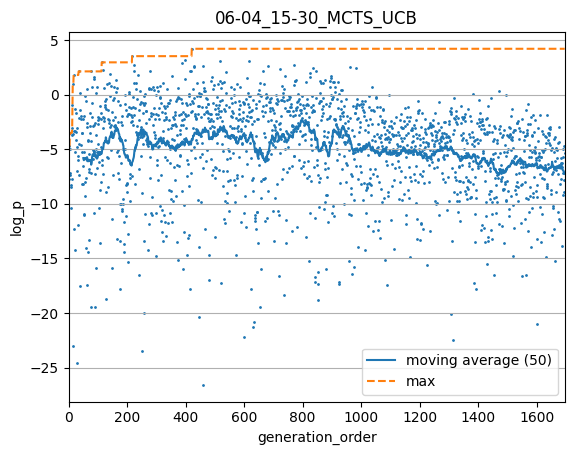

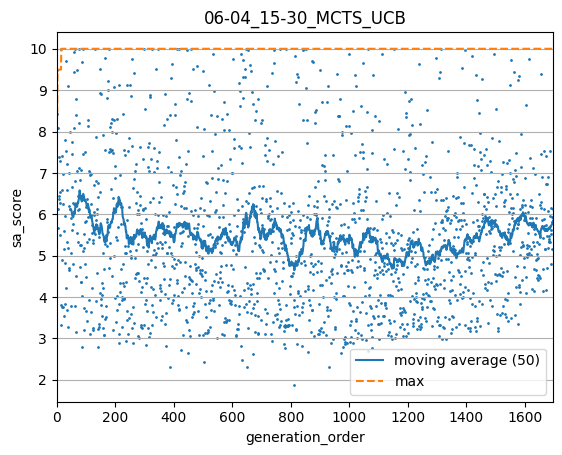

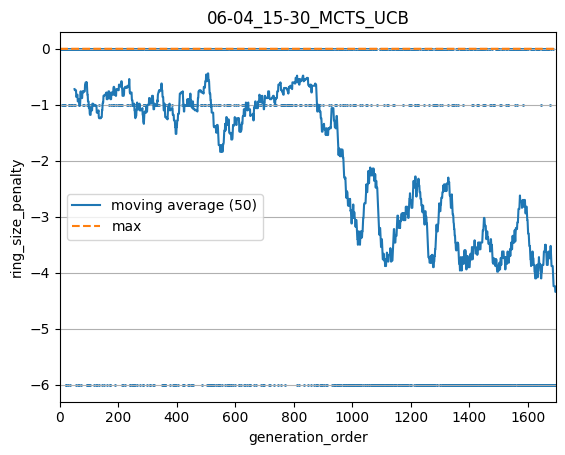

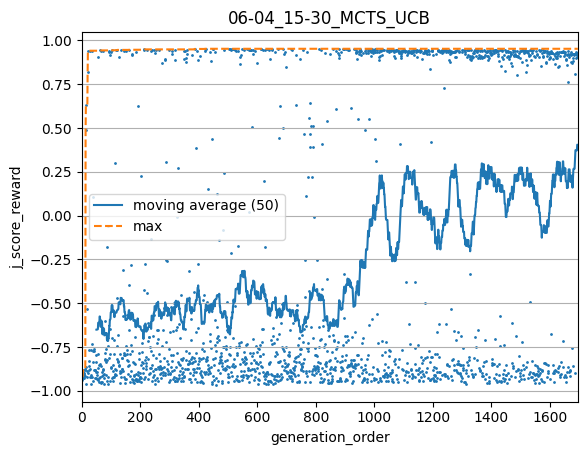

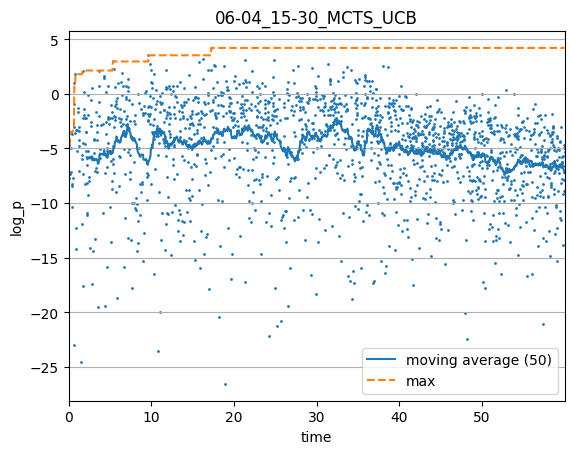

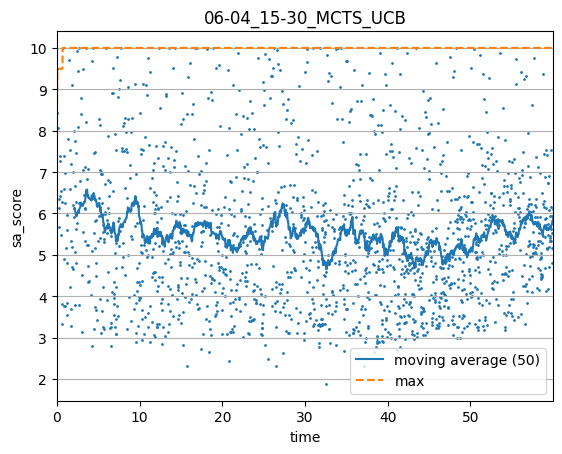

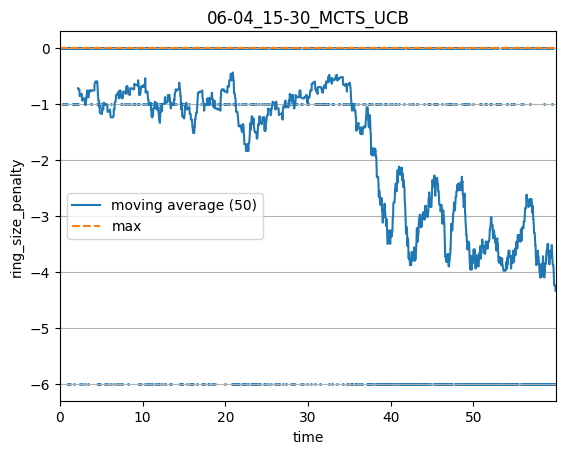

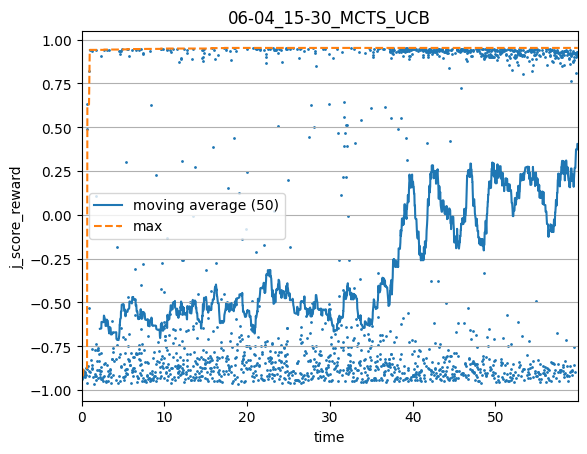

'generation_result/06-04_15-30_MCTS_UCB/setting.yaml'

In [ ]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

src = repo_root + config_path
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

generator.plot_objective_values_and_reward(x_axis = "generation_order")
generator.plot_objective_values_and_reward(x_axis = "time")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)